# CIFAR 10 Color Reconstruction using Autoencoder

### Importing Libraries

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tensorflow.python.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from google.colab import files

In [2]:
#importing CIFAR-10 Dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data() 

170508288/170498071 [==============================] - 4s 0us/step


In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


Taking the dataset only for Ship and Airplane

In [4]:
y_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
index_1,index_2 = y_classes.index("airplane"), y_classes.index("ship")

X_train_airplane = X_train[(y_train == index_1).ravel()][:]
X_test_airplane = X_test[(y_test == index_1).ravel()][:]
X_train_ship = X_train[(y_train == index_2).ravel()][:]
X_test_ship = X_test[(y_test == index_2).ravel()][:]


Few examples for the Ship and Airplane Dataset

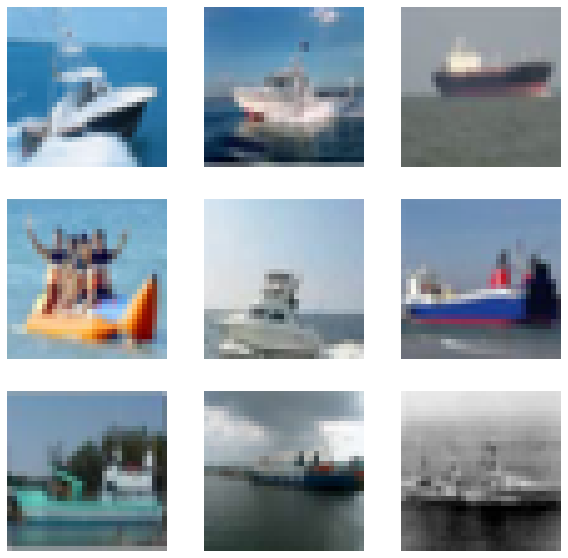

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train_ship[i])
  plt.axis("off")

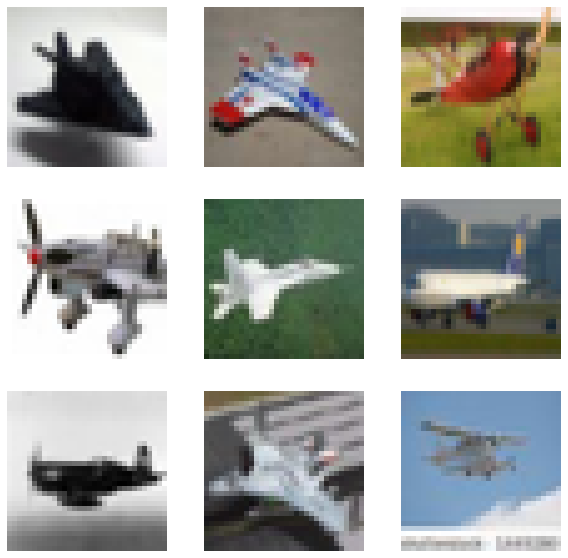

In [6]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train_airplane[i])
  plt.axis("off")

In [7]:
def rgb_2_gray(image):
	'''Function to convert RGB Image to Grayscale'''
	if len(image.shape)==3:
		gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
	else:
		gray_image = np.array([cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in image])
	return gray_image

Plotting Examples of Grayscale Images

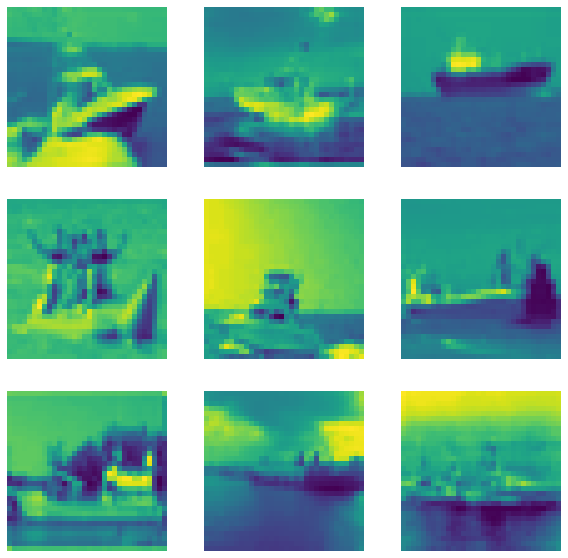

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(rgb_2_gray(X_train_ship[i]))
  plt.axis("off")

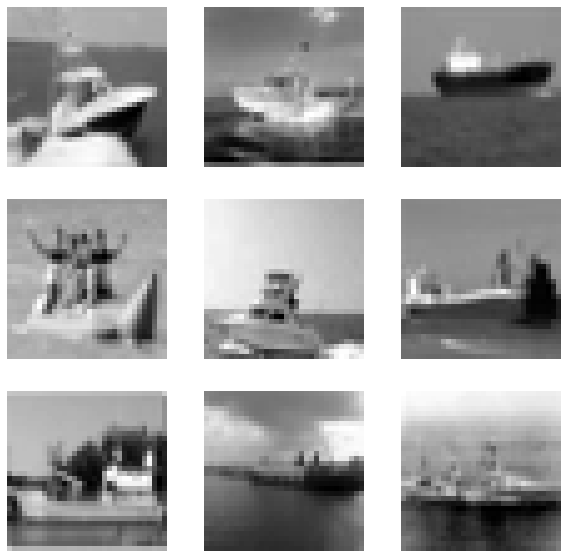

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(rgb_2_gray(X_train_ship[i]), cmap='gray')
  plt.axis("off")

### Preprocessing Dataset

In [10]:
#scaling the images by a factor of 255
X_train_airplane_gray = rgb_2_gray(X_train_airplane).astype('float32') / 255.
X_train_ship_gray = rgb_2_gray(X_train_ship).astype('float32') / 255.

X_train_airplane = X_train_airplane.astype('float32') / 255.
X_train_ship = X_train_ship.astype('float32') / 255.


In [11]:
X_test_airplane_gray = rgb_2_gray(X_test_airplane).astype('float32') / 255.
X_test_ship_gray = rgb_2_gray(X_test_ship).astype('float32') / 255.

X_test_airplane = X_test_airplane.astype('float32') / 255.
X_test_ship = X_test_ship.astype('float32') / 255.


### Architecture of Model

In [12]:
input_shape = (32, 32, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256 # dimensions of the encoded vector 
layer_filters = [128, 192, 256, 322]

In [13]:
#Encoder Input
inputs = Input(shape = input_shape)
x = inputs
for filters in layer_filters:
    x = Conv2D(filters = filters, kernel_size = kernel_size, strides = 2, activation ='relu',padding ='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name ='latent_vector')(x)
encoder = Model(inputs, latent, name ='encoder')

In [14]:
# Decoder Input
latent_inputs = Input(shape =(latent_dim, ), name ='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

#Decoder Output
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters = filters, kernel_size = kernel_size, strides = 2, activation ='relu', padding ='same')(x)
outputs = Conv2DTranspose(filters = 3, kernel_size = kernel_size, activation ='sigmoid', padding ='same', name ='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name ='decoder')


In [22]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name ='autoencoder')
colorification_autoencoder_early_stop=EarlyStopping(monitor='loss', patience=3)

In [23]:
autoencoder.compile(optimizer='adam', loss='mse')

In [24]:
colorification_training=autoencoder.fit(X_train_ship_gray,
				X_train_ship,
				validation_data =(X_test_ship_gray, X_test_ship),
				epochs = 30,
				batch_size = batch_size, callbacks=[colorification_autoencoder_early_stop])

Epoch 1/30
157/157 [==============================] - 10s 57ms/step - loss: 0.0045 - val_loss: 0.0112
Epoch 2/30
157/157 [==============================] - 9s 55ms/step - loss: 0.0044 - val_loss: 0.0114
Epoch 3/30
157/157 [==============================] - 9s 55ms/step - loss: 0.0044 - val_loss: 0.0111
Epoch 4/30
157/157 [==============================] - 9s 56ms/step - loss: 0.0042 - val_loss: 0.0111
Epoch 5/30
157/157 [==============================] - 9s 55ms/step - loss: 0.0041 - val_loss: 0.0110
Epoch 6/30
157/157 [==============================] - 9s 57ms/step - loss: 0.0041 - val_loss: 0.0115
Epoch 7/30
157/157 [==============================] - 9s 60ms/step - loss: 0.0039 - val_loss: 0.0111
Epoch 8/30
157/157 [==============================] - 8s 52ms/step - loss: 0.0038 - val_loss: 0.0111
Epoch 9/30
157/157 [==============================] - 8s 49ms/step - loss: 0.0038 - val_loss: 0.0112
Epoch 10/30
157/157 [==============================] - 8s 49ms/step - loss: 0.0038 - val_l

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


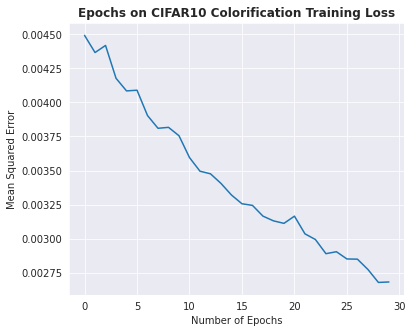

In [43]:
fig=plt.figure(figsize=(6, 5))
#plt.plot(colorification_training.epoch, colorification_training.history['loss'])
sns.set_style('darkgrid')
sns.lineplot(colorification_training.epoch, colorification_training.history['loss'])
plt.title('Epochs on CIFAR10 Colorification Training Loss', weight='bold')
plt.xlabel('Number of Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig("training loss on CIFAR10 colorification.png", bbox_inches='tight')
plt.show();

### Results for Ship Dataset

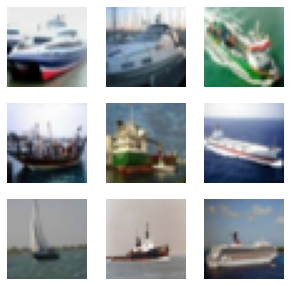

In [18]:
plt.figure(figsize=(5,5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test_ship[i])
  plt.axis("off")

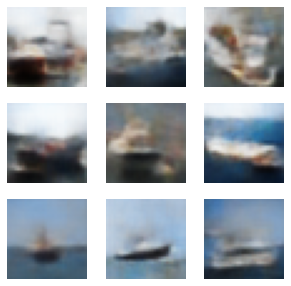

In [19]:
predictions = autoencoder.predict(X_test_ship_gray)

plt.figure(figsize=(5,5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(predictions[i])
  plt.axis("off")

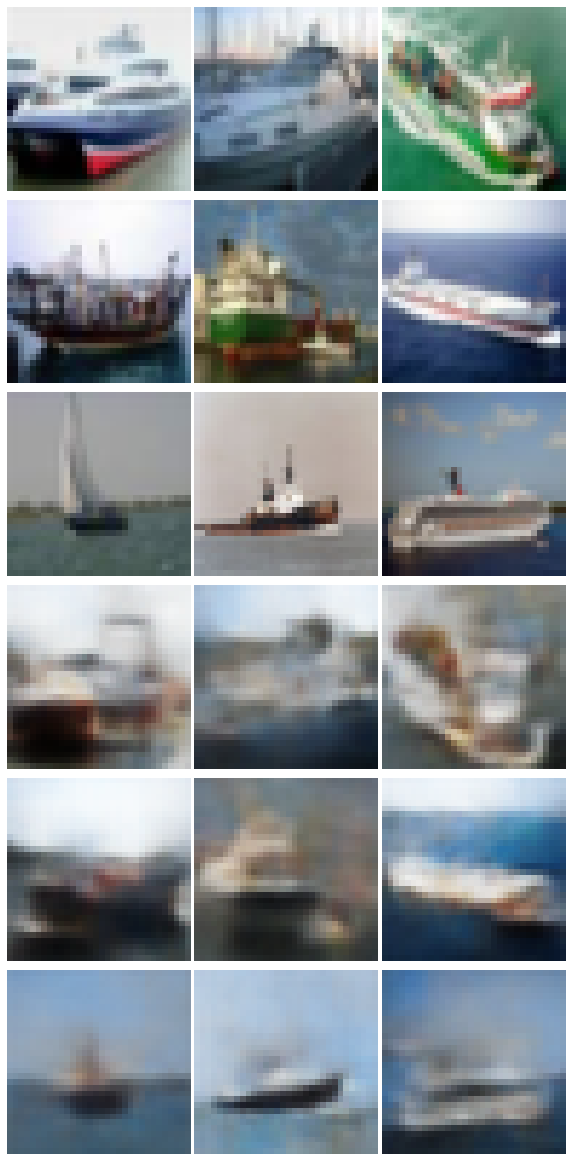

In [37]:
plt.figure(figsize=(10, 20))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.02, hspace=0.02)
for i in range(9):
  ax = plt.subplot(6, 3, i + 1)
  plt.imshow(X_test_ship[i])
  plt.axis("off")
for i in range(9, 18):
  ax = plt.subplot(6, 3, i + 1)
  plt.imshow(predictions[i-9])
  plt.axis("off")
plt.savefig('Actual vs Colorified images cifar10 boat.png', bbox_inches='tight')

We notice that the model has learnt features in general about ships which is common. Such as the ships are surrounded with water around the hull and surrounded with air above it, and predicted the colors correctly.

### To check whether Autoencoders are class specific

In [45]:
planes_predicted_on_ships = autoencoder.predict(X_test_airplane_gray)

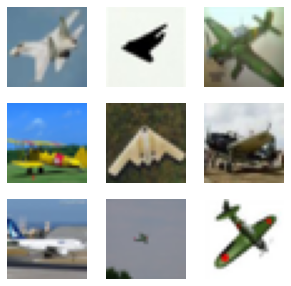

In [49]:
plt.figure(figsize=(5,5))
for i in range(1,10):
  ax = plt.subplot(3, 3, i)
  plt.imshow(X_test_airplane[i])
  plt.axis("off")

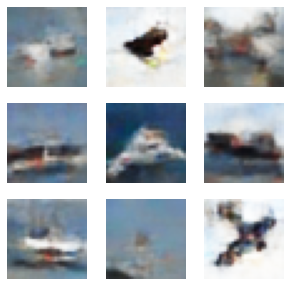

In [50]:
plt.figure(figsize=(5,5))
for i in range(1,10):
  ax = plt.subplot(3, 3, i )
  plt.imshow(planes_predicted_on_ships[i])
  plt.axis("off")

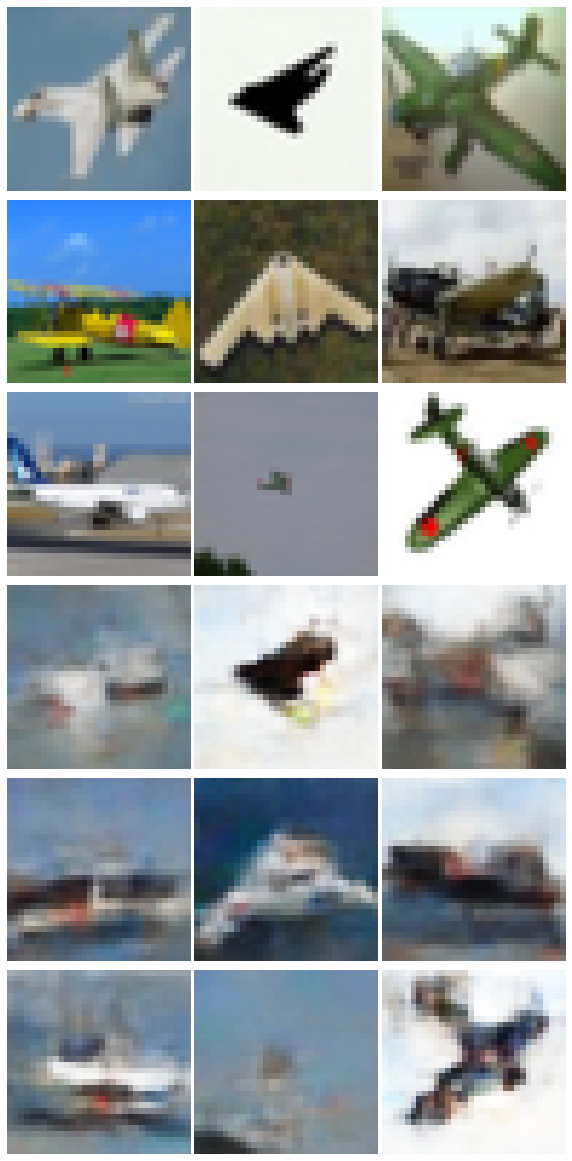

In [54]:
plt.figure(figsize=(10, 20))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.02, hspace=0.02)
for i in range(1,10):
  ax = plt.subplot(6, 3, i )
  plt.imshow(X_test_airplane[i])
  plt.axis("off")
for i in range(10, 19):
  ax = plt.subplot(6, 3, i)
  plt.imshow(planes_predicted_on_ships[i-9])
  plt.axis("off")
plt.savefig('planes predicted on ships.png', bbox_inches='tight')

Thus we notice that the model outputs erroneous results for Airplane Test data on the Ship Autoencoder Model. 

#### Thus we notice that colorified output learns features specific to a particular class. Thus training over the entire CIFAR 10 could lead to erroneous results. 